In [ ]:
import numpy as np
from numba import cuda, uint8, int32
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from Crypto.Random import get_random_bytes
from Crypto.Hash import SHA256
import time
 

In [ ]:

# dev = cuda.get_current_device()
# print(dev)


# for k, v in dev.get_device_attributes().items():
#     print(f"{k}: {v}")

In [ ]:
# AES parameters for AES-128
NR_ROUNDS = 10           # AES-128 has 10 rounds
EXPANDED_KEY_SIZE = 16 * (NR_ROUNDS + 1)  # 176 bytes for AES-128

#Encrypt
@cuda.jit(device=True)
def add_round_key(block,roundkey):
    block[0]  ^= roundkey[0]
    block[1]  ^= roundkey[1]
    block[2]  ^= roundkey[2]
    block[3]  ^= roundkey[3]
    block[4]  ^= roundkey[4]
    block[5]  ^= roundkey[5]
    block[6]  ^= roundkey[6]
    block[7]  ^= roundkey[7]
    block[8]  ^= roundkey[8]
    block[9]  ^= roundkey[9]
    block[10]  ^= roundkey[10]
    block[11]  ^= roundkey[11]
    block[12]  ^= roundkey[12]
    block[13]  ^= roundkey[13]
    block[14]  ^= roundkey[14]
    block[15]  ^= roundkey[15]

# RotByte: [a b c d] → [b c d a]
@cuda.jit(device=True)
def RotByte(word):
    temp=word[0]
    word[0]=word[1]
    word[1]=word[2]
    word[2]=word[3]
    word[3]=temp
    

# SubByte: applies S-box to 4 bytes
@cuda.jit(device=True)
def SubByte(word,sbox):
    word[0] = sbox[word[0]]
    word[1] = sbox[word[1]]
    word[2] = sbox[word[2]]
    word[3] = sbox[word[3]]


# -----------------------------------
# KeyExpansion
# AES-128 → output = 176 bytes
# -----------------------------------
@cuda.jit(device=True)
def key_expansion_device(cipher_key,expanded_key,rcon,sbox):

    #Copy the initial 16 bytes
    for i in range(16):
        expanded_key[i]=cipher_key[i]
    
    #expand the remaining  160 bytes
    temp = cuda.local.array(4, uint8)
    
    #i index grows  4 bytes at a time
    for i in range (16, EXPANDED_KEY_SIZE, 4):

        #temp = previous word
        for j in range(4):
            temp[j]=expanded_key[i-4+j]

        #Every Fourth word -> special transform 
        if i % 16 ==0:
            RotByte(temp)
            SubByte(temp,sbox)
            temp[0]^=rcon[i//16]   # rcon[1], rcon[2], ...

        #W[i] = W[i-16] XOR temp
        for j in range(4):
            expanded_key[i+j]=expanded_key[i-16 +j ] ^  temp[j]

@cuda.jit(device=True)
def mix_columns(block,mul2,mul3):
    #temp buffer (16 bytes)
    temp = cuda.local.array(16,uint8)

    #process 4 columns
    for col in range(4):
        a0=block[4*col +0]
        a1=block[4*col +1]
        a2=block[4*col +2]
        a3=block[4*col +3]

        #Same logic as original cuda
        temp[4*col+0]=mul2[a0] ^ mul3[a1] ^ a2 ^ a3
        temp[4*col+1]=a0 ^ mul2[a1] ^ mul3[a2] ^ a3
        temp[4*col+2]=a0 ^ a1 ^ mul2[a2] ^ mul3[a3]
        temp[4*col+3]=mul3[a0] ^ a1^ a2 ^ mul2[a3]

    #Copy the result back to the block
    for i in range(16):
        block[i]=temp[i]

@cuda.jit(device=True)
def shift_rows(block):
       # --------------------------------------
    # ROW 0: No shift
    # --------------------------------------

    # --------------------------------------
    # ROW 1: Shift left by 1
    # indices: 1, 5, 9, 13
    # --------------------------------------
    temp = block[1]
    block[1]=block[5]
    block[5]=block[9]
    block[9]=block[13]
    block[13]=temp

    # --------------------------------------
    # ROW 2: Shift left by 2
    # indices: 2 ↔ 10, 6 ↔ 14
    # --------------------------------------

    temp = block[2]
    block[2]=block[10]
    block[10]=temp

    temp = block[6]
    block[6]=block[14]
    block[14]=temp

    # --------------------------------------
    # ROW 3: Shift left by 3 (or right by 1)
    # indices: 3, 7, 11, 15
    # --------------------------------------

    temp = block[15]
    block[15]=block[11]
    block[11]=block[7]
    block[7]=block[3]
    block[3]=temp

@cuda.jit(device=True)
def sub_bytes(block,sbox):
    for i in range(16):
        block[i]=sbox[block[i]]

@cuda.jit(device = True)
def round_function(block,roundkey,sbox,mul2,mul3):
    #Apply Subbytes
    sub_bytes(block,sbox)
    #Apply ShiftRows
    shift_rows(block)
    #Apply MixColumns
    mix_columns(block,mul2,mul3)
    #Apply AddRoundKey
    add_round_key(block,roundkey)




@cuda.jit
def aes_private_sharedlut(state, cipherKey, state_length, grcon, gsbox, gmul2, gmul3):
    """
    state         : 1D uint8 device array (input/output)
    cipherKey     : 1D uint8 device array (length 16)
    state_length  : total bytes in state (int)
    grcon, gsbox, gmul2, gmul3 : 1D uint8 device arrays (256 each)
    """

    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    bdx = cuda.blockDim.x

    index = (tx + bdx * bx) * 16  # byte index of this thread's AES block

    # -------------------------
    # Shared LUTs (256 bytes)
    # -------------------------
    s_rcon = cuda.shared.array(256, uint8)
    s_sbox = cuda.shared.array(256, uint8)
    s_mul2 = cuda.shared.array(256, uint8)
    s_mul3 = cuda.shared.array(256, uint8)

    # Load LUTs from global -> shared
    if bdx < 256:
        if tx == 0:
            for i in range(256):
                s_rcon[i] = grcon[i]
                s_sbox[i] = gsbox[i]
                s_mul2[i] = gmul2[i]
                s_mul3[i] = gmul3[i]
    else:
        if tx < 256:
            s_rcon[tx] = grcon[tx]
            s_sbox[tx] = gsbox[tx]
            s_mul2[tx] = gmul2[tx]
            s_mul3[tx] = gmul3[tx]

    cuda.syncthreads()

    # -------------------------
    # Shared expanded key (176 bytes)
    # -------------------------
    s_expanded = cuda.shared.array(EXPANDED_KEY_SIZE, uint8)

    # Only thread 0 performs key expansion (per block)
    if tx == 0:
        key_expansion_device(cipherKey, s_expanded, s_rcon, s_sbox)

    cuda.syncthreads()

    # -------------------------
    # Local (per-thread) state buffer
    # -------------------------
    state_local = cuda.local.array(16, uint8)

    # Load block into local buffer (only if within range)
    if index + 16 <= state_length:
        for i in range(16):
            state_local[i] = state[index + i]
    else:
        return  # out-of-range thread does nothing

    # -------------------------
    # AES encryption using shared expanded key + shared LUTs
    # -------------------------
    # Initial AddRoundKey (round 0) — copy round key to local buffer first
    round_key_local = cuda.local.array(16, uint8)
    # offset for round 0
    offset = 0
    for j in range(16):
        round_key_local[j] = s_expanded[offset + j]
    add_round_key(state_local, round_key_local)

    # Middle rounds
    offset = 16
    for r in range(1, NR_ROUNDS):
        # copy round key for this round into local buffer
        for j in range(16):
            round_key_local[j] = s_expanded[offset + j]
        # perform one AES round (SubBytes, ShiftRows, MixColumns, AddRoundKey)
        round_function(state_local, round_key_local, s_sbox, s_mul2, s_mul3)
        offset += 16

    # Final round (no MixColumns)
    sub_bytes(state_local, s_sbox)
    shift_rows(state_local)
    # final round key (round NR_ROUNDS)
    for j in range(16):
        round_key_local[j] = s_expanded[NR_ROUNDS * 16 + j]
    add_round_key(state_local, round_key_local)

    # -------------------------
    # Write back to global memory
    # -------------------------
    for i in range(16):
        state[index + i] = state_local[i]




In [ ]:
@cuda.jit
def inv_AES (state,cipher_key,statelength,grcon,gsbox,ginvsbox,gmul2,gmul3):
    #compute block index
    idx = (cuda.threadIdx.x + cuda.blockDim.x*cuda.blockIdx.x)*16

    #Shared memory lookuptable
    s_rcon   = cuda.shared.array(shape=256,dtype=uint8)
    s_sbox   = cuda.shared.array(shape=256,dtype=uint8)
    s_invbox = cuda.shared.array(shape=256,dtype=uint8)
    s_mul2   = cuda.shared.array(shape=256,dtype=uint8)
    s_mul3   = cuda.shared.array(shape=256,dtype=uint8)

    #load LUts in to the shared memory
    tx  = cuda.threadIdx.x
    bdx = cuda.blockDim.x

    if bdx <256:
        #thread 0 loads  everything
        if tx==0:
            for i in range(256):
                s_rcon[i]=grcon[i]                 
                s_sbox[i]=gsbox[i]
                s_invbox[i]=ginvsbox[i]
                s_mul2[i]=gmul2[i]
                s_mul3[i]=gmul3[i]
    else:
        #first 256 threads does the work  cooperatively
        if tx<256:
             s_rcon[tx]=grcon[tx]                 
             s_sbox[tx]=gsbox[tx]
             s_invbox[tx]=ginvsbox[tx]
             s_mul2[tx]=gmul2[tx]
             s_mul3[tx]=gmul3[tx]

    cuda.syncthreads()

    #shared expanded key
    s_expanded = cuda.shared.array(shape=EXPANDED_KEY_SIZE,dtype=uint8)

    # only thread 0 expands the key

    if tx==0:
        key_expansion_device(cipher_key,s_expanded,s_rcon,s_sbox)

    cuda.syncthreads()


    #Load the State bloc in to the private memory
    stateLocal=cuda.local.array(16,uint8)

    if idx +16 <=statelength:
        for i in range(16):
            stateLocal[i]=state[idx +i]

   #Decrypt the block
    if idx + 16 <= statelength:
    
        # ---------------------------
        # 1) LAST ROUND KEY (round 10)
        # ---------------------------
        round_key_local = cuda.local.array(16, uint8)
        key_offset = 16 * NR_ROUNDS
    
        # copy key manually (NO slicing!)
        for j in range(16):
            round_key_local[j] = s_expanded[key_offset + j]
    
        # apply last round key
        add_round_key(stateLocal, round_key_local)
    
    
        # ---------------------------
        # 2) MIDDLE ROUNDS (round 9 → 1)
        # ---------------------------
        for r in range(1, NR_ROUNDS):
            key_offset = 16 * (NR_ROUNDS - r)
    
            # copy key for this round
            for j in range(16):
                round_key_local[j] = s_expanded[key_offset + j]
    
            inv_round(stateLocal,
                      round_key_local,
                      s_invbox,
                      s_mul2,
                      s_mul3)
    
    
        # ---------------------------
        # 3) FINAL ROUND (round 0)
        # ---------------------------
        # load round 0 key (offset 0)
        for j in range(16):
            round_key_local[j] = s_expanded[j]
    
        inv_final_round(stateLocal, round_key_local, s_invbox)

    # ======== Write Back Result ========
    if idx + 16 <= statelength:
        for i in range(16):
            state[idx + i] = stateLocal[i]


@cuda.jit(device=True)
def inv_final_round(block,roundkey,invsbox):
    #Invert shift rows
    inv_shift_rows(block)

    # Inverse SubBytes
    inv_subbytes(block, invsbox)

    # AddRoundKey
    add_round_key(block,roundkey)

@cuda.jit(device=True)
def inv_mixcols(block, mul2,mul3): # mul3 is unused but kept for API consistency
    u= uint8(0)
    v= uint8(0)

    for col in range(4):
        #u =mul2[mul2[(block[col*4]^block[col*4+2])]]
        t1 = block[4*col]^block[4*col+2]
        u =mul2 [mul2[t1]]

        #v = mul2[mul2[(block[col*4+1]^block[col*4+3])]]
        t2 = block[col*4+1]^block[col*4+3]
        v =mul2[mul2[t2]]

        #Apply the XORs
        block [4* col]^= u 
        block [4* col + 1]^=v
        block [4* col + 2]^=u
        block [4* col + 3]^=v

    mix_columns(block, mul2, mul3)

@cuda.jit(device= True)
def inv_round(block,round_key,invsbox,mul2,mul3):
    
    # Inverse ShiftRows
    inv_shift_rows(block)

    # Inverse SubBytes
    inv_subbytes(block, invsbox)

    # AddRoundKey
    add_round_key(block,round_key)

    # Inverse MixColumns
    inv_mixcols(block,mul2,mul3)

@cuda.jit(device= True)
def inv_shift_rows(block):
    #  ROW 0: Untouched

    # ROW 1: Shift right by one

    
    temp = block[13]
    block[13] = block[9]
    block[9] = block[5]
    block[5] = block[1]
    block[1] = temp

    #ROW 2: Shift right by two
    temp = block[14]
    block[14] = block[6]
    block[6] = temp
    temp = block[10]
    block[10] = block[2]
    block[2] = temp

    # ROW 3: Shift right by three
    temp = block[3]
    block[3] = block[7]
    block[7] = block[11]
    block[11] = block[15]
    block[15] = temp

@cuda.jit(device=True)
def inv_subbytes(block, invsbox):
    for i in range(16):
        block[i]= invsbox[block[i]]

In [ ]:
from numba import cuda,uint8
import numpy as np
# NUMBA_CUDA_PROFILE=1 python yourfile.py




SBOX=np.array([
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    	    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    	    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    	    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    	    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    	    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    	    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    	    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    	    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    	    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    	    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    	    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    	    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    	    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    	    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    	    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
        ], dtype=np.uint8)
INV_SBOX = np.array([
            0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
            0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
            0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
            0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
            0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
            0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
            0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
            0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
            0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
            0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
            0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
            0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
            0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
            0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
            0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
            0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D, 
        ], dtype=np.uint8)
RCON  = np.array([
            0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a,
    	    0x2f, 0x5e, 0xbc, 0x63, 0xc6, 0x97, 0x35, 0x6a, 0xd4, 0xb3, 0x7d, 0xfa, 0xef, 0xc5, 0x91, 0x39,
    	    0x72, 0xe4, 0xd3, 0xbd, 0x61, 0xc2, 0x9f, 0x25, 0x4a, 0x94, 0x33, 0x66, 0xcc, 0x83, 0x1d, 0x3a,
    	    0x74, 0xe8, 0xcb, 0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8,
    	    0xab, 0x4d, 0x9a, 0x2f, 0x5e, 0xbc, 0x63, 0xc6, 0x97, 0x35, 0x6a, 0xd4, 0xb3, 0x7d, 0xfa, 0xef,
    	    0xc5, 0x91, 0x39, 0x72, 0xe4, 0xd3, 0xbd, 0x61, 0xc2, 0x9f, 0x25, 0x4a, 0x94, 0x33, 0x66, 0xcc,
        	0x83, 0x1d, 0x3a, 0x74, 0xe8, 0xcb, 0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1b,
        	0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a, 0x2f, 0x5e, 0xbc, 0x63, 0xc6, 0x97, 0x35, 0x6a, 0xd4, 0xb3,
        	0x7d, 0xfa, 0xef, 0xc5, 0x91, 0x39, 0x72, 0xe4, 0xd3, 0xbd, 0x61, 0xc2, 0x9f, 0x25, 0x4a, 0x94,
        	0x33, 0x66, 0xcc, 0x83, 0x1d, 0x3a, 0x74, 0xe8, 0xcb, 0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20,
        	0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a, 0x2f, 0x5e, 0xbc, 0x63, 0xc6, 0x97, 0x35,
        	0x6a, 0xd4, 0xb3, 0x7d, 0xfa, 0xef, 0xc5, 0x91, 0x39, 0x72, 0xe4, 0xd3, 0xbd, 0x61, 0xc2, 0x9f,
        	0x25, 0x4a, 0x94, 0x33, 0x66, 0xcc, 0x83, 0x1d, 0x3a, 0x74, 0xe8, 0xcb, 0x8d, 0x01, 0x02, 0x04,
        	0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a, 0x2f, 0x5e, 0xbc, 0x63,
        	0xc6, 0x97, 0x35, 0x6a, 0xd4, 0xb3, 0x7d, 0xfa, 0xef, 0xc5, 0x91, 0x39, 0x72, 0xe4, 0xd3, 0xbd,
        	0x61, 0xc2, 0x9f, 0x25, 0x4a, 0x94, 0x33, 0x66, 0xcc, 0x83, 0x1d, 0x3a, 0x74, 0xe8, 0xcb, 0x8d
        ], dtype=np.uint8)
MUL2 = np.array([
            0x00, 0x02, 0x04, 0x06, 0x08, 0x0a, 0x0c, 0x0e, 0x10, 0x12, 0x14, 0x16, 0x18, 0x1a, 0x1c, 0x1e,
        	0x20, 0x22, 0x24, 0x26, 0x28, 0x2a, 0x2c, 0x2e, 0x30, 0x32, 0x34, 0x36, 0x38, 0x3a, 0x3c, 0x3e,
        	0x40, 0x42, 0x44, 0x46, 0x48, 0x4a, 0x4c, 0x4e, 0x50, 0x52, 0x54, 0x56, 0x58, 0x5a, 0x5c, 0x5e,
        	0x60, 0x62, 0x64, 0x66, 0x68, 0x6a, 0x6c, 0x6e, 0x70, 0x72, 0x74, 0x76, 0x78, 0x7a, 0x7c, 0x7e,
        	0x80, 0x82, 0x84, 0x86, 0x88, 0x8a, 0x8c, 0x8e, 0x90, 0x92, 0x94, 0x96, 0x98, 0x9a, 0x9c, 0x9e,
        	0xa0, 0xa2, 0xa4, 0xa6, 0xa8, 0xaa, 0xac, 0xae, 0xb0, 0xb2, 0xb4, 0xb6, 0xb8, 0xba, 0xbc, 0xbe,
        	0xc0, 0xc2, 0xc4, 0xc6, 0xc8, 0xca, 0xcc, 0xce, 0xd0, 0xd2, 0xd4, 0xd6, 0xd8, 0xda, 0xdc, 0xde,
        	0xe0, 0xe2, 0xe4, 0xe6, 0xe8, 0xea, 0xec, 0xee, 0xf0, 0xf2, 0xf4, 0xf6, 0xf8, 0xfa, 0xfc, 0xfe,
        	0x1b, 0x19, 0x1f, 0x1d, 0x13, 0x11, 0x17, 0x15, 0x0b, 0x09, 0x0f, 0x0d, 0x03, 0x01, 0x07, 0x05,
        	0x3b, 0x39, 0x3f, 0x3d, 0x33, 0x31, 0x37, 0x35, 0x2b, 0x29, 0x2f, 0x2d, 0x23, 0x21, 0x27, 0x25,
        	0x5b, 0x59, 0x5f, 0x5d, 0x53, 0x51, 0x57, 0x55, 0x4b, 0x49, 0x4f, 0x4d, 0x43, 0x41, 0x47, 0x45,
        	0x7b, 0x79, 0x7f, 0x7d, 0x73, 0x71, 0x77, 0x75, 0x6b, 0x69, 0x6f, 0x6d, 0x63, 0x61, 0x67, 0x65,
        	0x9b, 0x99, 0x9f, 0x9d, 0x93, 0x91, 0x97, 0x95, 0x8b, 0x89, 0x8f, 0x8d, 0x83, 0x81, 0x87, 0x85,
        	0xbb, 0xb9, 0xbf, 0xbd, 0xb3, 0xb1, 0xb7, 0xb5, 0xab, 0xa9, 0xaf, 0xad, 0xa3, 0xa1, 0xa7, 0xa5,
        	0xdb, 0xd9, 0xdf, 0xdd, 0xd3, 0xd1, 0xd7, 0xd5, 0xcb, 0xc9, 0xcf, 0xcd, 0xc3, 0xc1, 0xc7, 0xc5,
        	0xfb, 0xf9, 0xff, 0xfd, 0xf3, 0xf1, 0xf7, 0xf5, 0xeb, 0xe9, 0xef, 0xed, 0xe3, 0xe1, 0xe7, 0xe5
        ],dtype=np.uint8)
MUL3 = np.array([
            0x00, 0x03, 0x06, 0x05, 0x0c, 0x0f, 0x0a, 0x09, 0x18, 0x1b, 0x1e, 0x1d, 0x14, 0x17, 0x12, 0x11,
        	0x30, 0x33, 0x36, 0x35, 0x3c, 0x3f, 0x3a, 0x39, 0x28, 0x2b, 0x2e, 0x2d, 0x24, 0x27, 0x22, 0x21,
        	0x60, 0x63, 0x66, 0x65, 0x6c, 0x6f, 0x6a, 0x69, 0x78, 0x7b, 0x7e, 0x7d, 0x74, 0x77, 0x72, 0x71,
        	0x50, 0x53, 0x56, 0x55, 0x5c, 0x5f, 0x5a, 0x59, 0x48, 0x4b, 0x4e, 0x4d, 0x44, 0x47, 0x42, 0x41,
        	0xc0, 0xc3, 0xc6, 0xc5, 0xcc, 0xcf, 0xca, 0xc9, 0xd8, 0xdb, 0xde, 0xdd, 0xd4, 0xd7, 0xd2, 0xd1,
        	0xf0, 0xf3, 0xf6, 0xf5, 0xfc, 0xff, 0xfa, 0xf9, 0xe8, 0xeb, 0xee, 0xed, 0xe4, 0xe7, 0xe2, 0xe1,
        	0xa0, 0xa3, 0xa6, 0xa5, 0xac, 0xaf, 0xaa, 0xa9, 0xb8, 0xbb, 0xbe, 0xbd, 0xb4, 0xb7, 0xb2, 0xb1,
        	0x90, 0x93, 0x96, 0x95, 0x9c, 0x9f, 0x9a, 0x99, 0x88, 0x8b, 0x8e, 0x8d, 0x84, 0x87, 0x82, 0x81,
        	0x9b, 0x98, 0x9d, 0x9e, 0x97, 0x94, 0x91, 0x92, 0x83, 0x80, 0x85, 0x86, 0x8f, 0x8c, 0x89, 0x8a,
        	0xab, 0xa8, 0xad, 0xae, 0xa7, 0xa4, 0xa1, 0xa2, 0xb3, 0xb0, 0xb5, 0xb6, 0xbf, 0xbc, 0xb9, 0xba,
        	0xfb, 0xf8, 0xfd, 0xfe, 0xf7, 0xf4, 0xf1, 0xf2, 0xe3, 0xe0, 0xe5, 0xe6, 0xef, 0xec, 0xe9, 0xea,
        	0xcb, 0xc8, 0xcd, 0xce, 0xc7, 0xc4, 0xc1, 0xc2, 0xd3, 0xd0, 0xd5, 0xd6, 0xdf, 0xdc, 0xd9, 0xda,
        	0x5b, 0x58, 0x5d, 0x5e, 0x57, 0x54, 0x51, 0x52, 0x43, 0x40, 0x45, 0x46, 0x4f, 0x4c, 0x49, 0x4a,
        	0x6b, 0x68, 0x6d, 0x6e, 0x67, 0x64, 0x61, 0x62, 0x73, 0x70, 0x75, 0x76, 0x7f, 0x7c, 0x79, 0x7a,
        	0x3b, 0x38, 0x3d, 0x3e, 0x37, 0x34, 0x31, 0x32, 0x23, 0x20, 0x25, 0x26, 0x2f, 0x2c, 0x29, 0x2a,
        	0x0b, 0x08, 0x0d, 0x0e, 0x07, 0x04, 0x01, 0x02, 0x13, 0x10, 0x15, 0x16, 0x1f, 0x1c, 0x19, 0x1a
        ],dtype=np.uint8)

class AES_encrypt_decrypt:
    def __init__(self):

        #pre-load lookup tables
        self.sbox     = (SBOX)
        self.invsbox  = (INV_SBOX)
        self.rcon     = (RCON)
        self.mul2     = (MUL2)
        self.mul3     = (MUL3)
        self.invSbox  = (INV_SBOX)
        # self.make_uint8_array(

    def encrypt_gpu(self,state,cipherkey,statelength,block_size=None):

        #pad input 
        if len(state)%16 !=0:
            pad = 16 - (len(state)%16)
            state = np.concatenate([state,np.zeros(pad,dtype=np.uint8)])

        nbytes = len (state)

        #Copy inputs to GPU

        d_state     = cuda.to_device(state)
        d_cipherkey = cuda.to_device(cipherkey)
        d_sbox      = cuda.to_device(self.sbox)
        d_rcon      = cuda.to_device(self.rcon)
        d_mul2      = cuda.to_device(self.mul2)
        d_mul3      = cuda.to_device(self.mul3)

        # if block_size is None:
        #     block_size = (statelength-1)//16 + 1
        #     grid_size  = 1

        #     if (block_size >1024):
        #         block_size = 1024
        #         grid_size = (statelength-1)//16 + 1
        #     else:
        #         grid_size = (statelength-1) // (block_size * 16) +1

        #     blokDim = (block_size,1,1)
        #     gridDim = (grid_size,1,1)

            #------------GRID/Block optimized-----------
        # Correct number of AES blocks
        nblocks = statelength // 16
        
        # Optimal threads per block
        threads_per_block = 256  # or 512 or 1024
        
        # Number of CUDA blocks to launch
        blocks_per_grid = (nblocks + threads_per_block - 1) // threads_per_block

        start = cuda.event()
        end = cuda.event()

        start.record()
        #Call kernel
        aes_private_sharedlut[blocks_per_grid,threads_per_block](
        d_state, d_cipherkey, nbytes,
        d_rcon, d_sbox,  d_mul2, d_mul3
    )
        # wait for completion            
        end.record()
        end.synchronize()
        time_ms = cuda.event_elapsed_time(start, end)
        
        return d_state.copy_to_host(),time_ms


    def decrypt_gpu(self, state, cipherkey, statelength, block_size=1024):

        # ----------- PAD INPUT ------------
        if statelength % 16 != 0:
            pad = 16 - (statelength % 16)
            state = np.concatenate([state, np.zeros(pad, dtype=np.uint8)])
            statelength += pad

        nbytes = statelength

       
        # ---------- COPY TO GPU ----------
        d_state     = cuda.to_device(state)
        d_cipherkey = cuda.to_device(cipherkey)
        d_rcon      = cuda.to_device(self.rcon)
        d_sbox      = cuda.to_device(self.sbox)
        d_invsbox   = cuda.to_device(self.invSbox)
        d_mul2      = cuda.to_device(self.mul2)
        d_mul3      = cuda.to_device(self.mul3)



        #------------GRID/Block optimized-----------
        # Correct number of AES blocks
        nblocks = statelength // 16
        
        # Optimal threads per block
        threads_per_block = 256  # or 512 or 1024
        
        # Number of CUDA blocks to launch
        blocks_per_grid = (nblocks + threads_per_block - 1) // threads_per_block


        # threads_per_block = block_size
        # blocks_per_grid   = grid_size

        start = cuda.event()
        end = cuda.event()

        start.record()
        # ------------ LAUNCH KERNEL -------------
        inv_AES[blocks_per_grid, threads_per_block](
            d_state,
            d_cipherkey,
            np.uint32(nbytes),
            d_rcon,
            d_sbox,
            d_invsbox,
            d_mul2,
            d_mul3
        )
        
        # (state,cipher_key,statelength,grcon,gsbox,ginvsbox,gmul2,gmul3):

        end.record()
        end.synchronize()

        #Excution time
        time_ms = cuda.event_elapsed_time(start, end)

        # ------------ RETURN HOST RESULT ----------
        return (d_state.copy_to_host(),time_ms)

    def encrypt_cpu(self,plaintext, key):
        # Create an AES cipher object with the key and AES.MODE_ECB mode
        cipher = AES.new(key, AES.MODE_ECB)

        start = time.perf_counter()
        # Pad the plaintext and encrypt it
        ciphertext = cipher.encrypt(pad(plaintext, AES.block_size))

        end = time.perf_counter()

        total_time = (end -start)*1000
        
        return ciphertext, total_time
 
    def decrypt_cpu(self,ciphertext, key):
        # Create an AES cipher object with the key and AES.MODE_ECB mode
        cipher = AES.new(key, AES.MODE_ECB)
        # Decrypt the ciphertext and remove the padding
        start = time.perf_counter()
        decrypted_data = unpad(cipher.decrypt(ciphertext), AES.block_size)
        end = time.perf_counter()
        total_time = (end -start)*1000
        return decrypted_data,total_time
    def get_key_from_string(self,key_str):
        # Create a SHA-256 hash of the string to derive a 32-byte AES key
        hash_obj = SHA256.new(key_str.encode())
        return hash_obj.digest()  # returns 32 bytes
        

In [ ]:

def runthecode(plaintext,cipherkey):
    
    
    # Convert to bytes
    text_bytes = plaintext.encode('utf-8')
    cipherkey_bytes = cipherkey.encode('utf-8')
    
    
    # Convert to numpy uint8 arrays
    state = np.frombuffer(text_bytes, dtype=np.uint8)
    plaintext_bytes = plaintext.encode("utf-8")
    cipherkey_arr = np.frombuffer(cipherkey_bytes, dtype=np.uint8)
    
    # AES needs this:
    statelength = len(state)
    
    
    
    # print("state:", state)
    # print("cipherkey:", cipherkey_arr)
    # print("statelength:", statelength)

    #Initialise the object
    test_code =AES_encrypt_decrypt()

    
    cpu_key=test_code.get_key_from_string(cipherkey)

    #encrypt the code gpu
    result_gpu, execution_time_encrypt_gpu =test_code.encrypt_gpu(state,cipherkey_arr,statelength)

    #encrypt the code cpu
    encrypted_data_cpu,execution_time_encrypt_cpu = test_code.encrypt_cpu(plaintext_bytes, cipherkey_bytes)

    #decrypt the cipher code gpu
    decrypted_gpu, execution_time_decrypt_gpu=test_code.decrypt_gpu(result_gpu,cipherkey_arr,statelength)

    #decrypt the cipher code cpu
    plaintext_cpu, execution_time_decrypt_cpu=test_code.decrypt_cpu(encrypted_data_cpu, cipherkey_bytes)


    
    plaintext_bytes = decrypted_gpu.astype(np.uint8).tobytes()

    # Remove trailing zero padding
    plaintext_bytes = plaintext_bytes.rstrip(b'\x00')
    
    plaintext_gpu = plaintext_bytes.decode('utf-8')

    return plaintext_gpu,plaintext_cpu,execution_time_encrypt_gpu,execution_time_encrypt_cpu,execution_time_decrypt_gpu,execution_time_decrypt_cpu

    
#Cipher Key
cipherkey = '0987654321098765' 

In [ ]:
%env NUMBA_CUDA_PROFILE=1

import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)   # GPU 0

def gpu_mem():
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    print(f"Used: {info.used/1024**2:.2f} MB / {info.total/1024**2:.2f} MB")

data={
    'len':[],
    'gpu_encrypt':[],
    'cpu_encrypt':[],
    'gpu_decrypt':[],
    'cpu_decrypt':[]
}
for i in range (1,9):
    k = 10**i
    # plaintext1 = np.random.randint(0, 256, size=k, dtype=np.uint8)
    text="".join(str(s) for s in np.random.randint(0, 256, size=k, dtype=np.uint8))
    gpu_mem()   # before encryption
    text_gpu,text_cpu,encrypt_time_gpu,encrypt_time_cpu,decrypt_time_gpu,decrypt_time_cpu=runthecode(text,cipherkey)
    gpu_mem()   # after encryption
    
    # print("The execution completed:\n\nencryption time(ms) -> \n gpu:{}\n cpu:{}\n \ndecryption time(ms) -> \n gpu:{}\n cpu:{}\n \nlength of decrypted message -> \n gpu:{}\n cpu:{}\n actual length{}\n\n\n".format(
    #     encrypt_time_gpu,encrypt_time_cpu,decrypt_time_gpu,decrypt_time_cpu,len(text_gpu),len(text_cpu),len(text)))
    data['len'].append(len(text))
    data['gpu_encrypt'].append(encrypt_time_gpu)
    data['cpu_encrypt'].append(encrypt_time_cpu)
    data['gpu_decrypt'].append(decrypt_time_gpu)
    data['cpu_decrypt'].append(decrypt_time_cpu)
    print(i)

env: NUMBA_CUDA_PROFILE=1
Used: 371.88 MB / 15360.00 MB
Used: 371.88 MB / 15360.00 MB
1
Used: 371.88 MB / 15360.00 MB
Used: 371.88 MB / 15360.00 MB
2
Used: 371.88 MB / 15360.00 MB
Used: 371.88 MB / 15360.00 MB
3
Used: 371.88 MB / 15360.00 MB
Used: 371.88 MB / 15360.00 MB
4
Used: 371.88 MB / 15360.00 MB
Used: 371.88 MB / 15360.00 MB
5
Used: 371.88 MB / 15360.00 MB
Used: 371.88 MB / 15360.00 MB
6
Used: 371.88 MB / 15360.00 MB
Used: 397.88 MB / 15360.00 MB
7
Used: 397.88 MB / 15360.00 MB
Used: 617.88 MB / 15360.00 MB
8


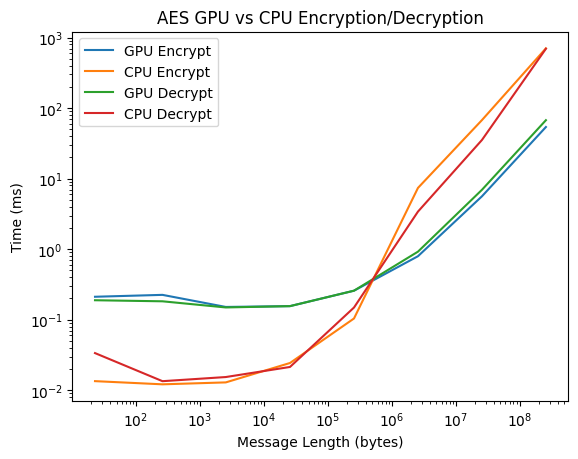

In [ ]:
import matplotlib.pyplot as plt


x = data['len']

plt.plot(x, data['gpu_encrypt'])
plt.plot(x, data['cpu_encrypt'])
plt.plot(x, data['gpu_decrypt'])
plt.plot(x, data['cpu_decrypt'])

plt.xlabel("Message Length (bytes)")
plt.ylabel("Time (ms)")
plt.title("AES GPU vs CPU Encryption/Decryption")
plt.xscale("log")
plt.yscale("log")

plt.legend(["GPU Encrypt", "CPU Encrypt", "GPU Decrypt", "CPU Decrypt"])
plt.show()
